<img align="right" style="max-width: 200px; height: auto" src="01_images/hsg_logo.png">

### Lab 02 - "Maschinelle Lern- und Analyseverfahren"

ACA Lehrgang "Internal Audit Knowledge Elements", Universität St. Gallen, 15. Januar 2020

Die Laborumgebung des Kurses **"Internal Audit Knowledge Elements"** an der Universität St. Gallen basiert auf Jupyter Notebooks (https://jupyter.org), die es erlauben, eine Vielzahl von statistischen Auswertungen und Datenanalysen durchzuführen.

Im letzten Lab lernten wir einige ausgewählte Elemente der grundlegenden Vorgehensweise des revisorischen Datenanalyseprozesses kennen. Darüber hinaus wurden Indikatorbasierte Analyseverfahren exemplarisch vorgestellt. In diesem Lab werden wir Jupyter Notebook nutzen, um ein erstes maschinelles Lernverfahren zu implementieren und anzuwenden. Zielsetzung ist es hierbei durch die Anwendung von (tiefen) **Neuronalen Autoencoder Netzen** automatisert ungewöhnliche Buchungen in einer Grundgesamtheit an Buchungen zu identifizieren.

<img align="center" style="max-width: 800px; height: auto" src="01_images/autoencoder.png">

Zögern Sie bitte nicht Fragen entweder unmittelbar während der Durchführung des Labs zu stellen oder uns im Nachgang eine E-Mail an marco.schreyer@unisg.ch zu senden.

### Lernziele des Labs:

Das vorliegende Lab sollte Ihnen ermöglichen:

>1. Finanzdaten für den Einsatz **maschineller Lernverfahren** aufzubereiten;
>2. die grundlegende Funktionsweise und Elemente von **Neuronalen Autoencoder Netzen** zu verstehen;
>3. Neuronale Autoencoder Netze zur Erkennung von **Anomalien** in Buchungs- und Transaktionsdaten einzusetzen;
>4. den **Rekonstruktionsverlust** pro Buchung bzw. Transaktion zu verstehen und interpretieren.

Aber bevor wir beginnen lassen Sie uns ein kurzes Motivationsvideo schauen:

In [1]:
from IPython.display import YouTubeVideo
# OpenAI: Solving Rubik’s Cube with a Robot Hand
# YouTubeVideo('x4O8pojMF0w', width=1024, height=576)

### 0. Analyseumgebung

In Analogie zu unseren vorhergehenden Labs, ist es zunächst wieder notwendig einige Python-Bibliotheken zu importieren die uns die Datenakquise, Datenanalyse und Datenvisualisierung erlauben. Im Rahmen dieses Labs werden wir im Besonderen die durch das Facebook AI Research Team (https://ai.facebook.com) entwickelte Deep-Learning Bibliothek **PyTorch** (https://pytorch.org) im Rahmen der Datenanalyse verwenden.

Importieren wir jedoch zu Beginn wieder ein paar "Utilities" Bibliotheken, welche wir im Verlauf dieses Labs an mehreren Stellen benötigen:

In [2]:
import os # ermöglicht den Zugriff auf das lokale Dateisystem
import datetime as dt # ermöglicht die Erstellung von Zeitstempeln

Importiere die Python Datenanalyse (oder "Data Science") Bibliotheken:

In [3]:
import pandas as pd
import random as rd
import numpy as np

Importiere die Python "Deep Learning" Bibliotheken:

In [4]:
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

Importiere die Python Datenvisualiserungs Bibliothek und setze globale Parameter der Datenvisualisierung:

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.dpi']= 150

Aktivieren das "Inline-Plotten" von Visualisierungen innerhalb des aktuellen Notebooks:

In [6]:
%matplotlib inline

Finally, let' set the seeds of random elements in the code e.g. the initialization of the network parameters to guarantee deterministic computation and results:

In [7]:
# init deterministic seed
seed_value = 1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed

Erstellung eines lokalen Unterordners mit Ordnerbezeichnung **"03_results"** für das Speichern der nachfolgend erzeugten Ergebnisdateien der durchgeführeten Analysen:

In [8]:
if not os.path.exists('./03_results'): os.makedirs('./03_results')

Erstellung eines lokalen Unterordners mit Ordnerbezeichnung **"04_models"** für das Speichern der nachfolgend erlenten Modelle im Rahmen des Netwerktrainings:

In [9]:
if not os.path.exists('./04_models'): os.makedirs('./04_models')

### 1. Datenimport

Der synthetische **PaySim** Datensatz simuliert mobile Geldtransaktionen auf der Basis realer Transaktionen, die aus einem Monat Finanzprotokolle eines in einem afrikanischen Land implementierten mobilen Finanzdienstleisters extrahiert wurden. Weitere Details des Datensatzes sowie der Datensatz selbst können über die nachfolgende Webseite: https://www.kaggle.com/ntnu-testimon/paysim1 bzw. Publikation bezogen werden: 

*E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016*

Das vorliegende Lab basiert auf einem angepassten extrakt diese Datensatzes. Der Datenbestand wurde um Datenfelder angepasst und Anomalien erweitert. Dies mit der Zielsetzung, eine hohe Änhnlichkeit zu einem Datenextrakt eines SAP-ERP Finanz- und Kostencontrollings (FICO) Modul aufzuweisen.

Jeder der im Datensatz enthaltenen Buchungen umfasst insgesamt sieben kateogrische und zwei numerische Buchungsmerkmale. Diese Merkmale stehen gewöhnlich in den SAP Tabellen **BKPF ("Belegköpfe")** und **BSEG ("Belegsegmente")** zur Verfügung. Die Merkmalsbezeichnungen sowie ihre jeweils semantische Bedeutung ist nachfolgend angeführt:

>- `BELNR`: die Buchhaltungsbelegnummer,
>- `BUKRS`: der Buchungskreis,
>- `BSCHL`: der Buchungsschlüssel,
>- `HKONT`: das gebuchte Hauptbuchkonto,
>- `PRCTR`: das gebuchte Profit Center,
>- `WAERS`: der Währungsschlüssel,
>- `KTOSL`: der Hauptbuchkontenschlüssel,
>- `DMBTR`: der Betrag in Systemwährung,
>- `WRBTR`: der Betrag in Belegwährung.

Darüber hinaus ist jede Buchung mit einem Kennzeichen versehen:

>- `label:` Kennzeichnet den Typ der Buchung ("regular", "local" oder "global").

Die einzelnen Buchungen können das `label` **"regular"** d.h. gewöhnliche Buchung, **"local"** d.h. lokale Anomalie oder **"global"** d.h. globale Anomalie aufweisen. Diese Information wird nachfolgend lediglich für die Evaluation der Güte des Verfahrens verwendet. Sie findet keinen Eingang in das Training der Modelle zur Anomaliedetektion.

Lassen Sie uns nun einen Teilextrakt des zuvor beschriebenen und aufbereiteten Datensatzes bestehend aus **533.009 Buchungen** in das Notebook importieren. Hierzu definieren wir zunächst den Pfad bzw. die URL der zu importierenden Buchungsdaten: 

In [10]:
# setzen der URL der zu beziehenden Buchungsdaten
url = 'https://raw.githubusercontent.com/GitiHubi/courseACA/master/lab02/02_data/transactions.csv'

Einlesen als Comma-Seperated-Value (CSV) in die Pandas Bibliothek:

In [11]:
ori_dataset = pd.read_csv(url)

Inspektion der ersten 10 im Datensatz enthaltenen Buchungen (Zeilen):

In [12]:
# inspect top rows of dataset
ori_dataset.head(10)

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


### 2. Datenvalidierung

Verifikation der Vollständigkeit der zu analysierenden Daten:

In [13]:
now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Buchungsdaten bestehend aus {} Zeilen und {} Spalten geladen.'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20200111-11:04:49] Buchungsdaten bestehend aus 533009 Zeilen und 10 Spalten geladen.


Analyse der Verteilung der regulären und ungewöhnlichen Buchungen des Datensatz:

In [14]:
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

Die Statistik zeigt, dass, ähnlich wie in der realen Welt, ein sehr unbalanciertes Verhältnis zwischen regulären Buchungen und Anomalien besteht. Insgesamt enthält der Datensatz nur einen kleinen Bruchteil von 100  anomalen Transaktionen (0,018% der Gesamtdaten). Während die 100 anomalen Einträge **70 (0,013%)** "globale" Anomalien und **30 (0,005%)** "lokale" Anomalien umfassen.

### 3. Datenaufbereitung

Entfernung der `label` Information der einzelnen Buchungen:

In [15]:
label = ori_dataset.pop('label')

#### 3.2. Aufbereitung kategorischer Datenfelder

Aus der ersten Inaugenscheinnahme der Buchungen ist zu erkennen, dass die Mehrzahl der in AIS- und ERP-Systemen erfassten Merkmale kategorialen (diskreten) Merkmalswerten entsprechen, z.B. das Buchungsdatum, das Hauptbuchkonto, die Art der Buchung oder Währung. Lassen Sie uns die Werteverteilung zwei der Merkmale im Datenbestand im Detail anschauen bzw. visualisieren, d.h. die Verteilung der verwendeten (1) Buchungsschlüssel (Merkmal `BSCHL`) sowie die Verteilung der gebuchten (2) das Hauptbuchkonten (Merkmal `HKONT`):

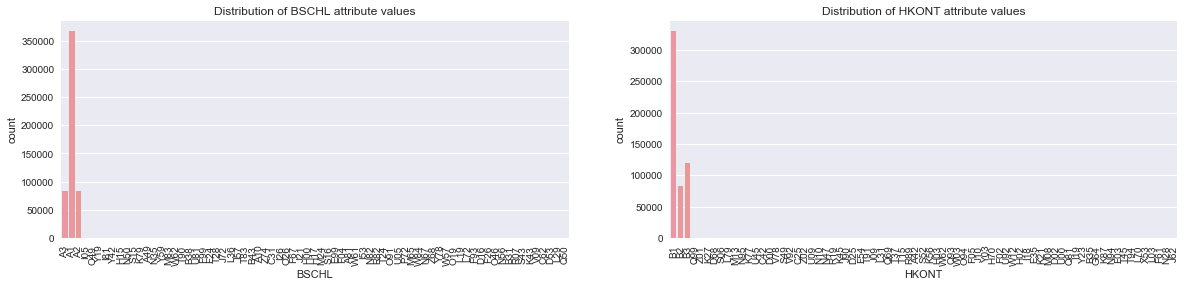

In [16]:
# initialisierung des Plots
fig, ax = plt.subplots(1,2)

# setzen der Breite des Plots
fig.set_figwidth(20)

# zeichnen der Verteilung des Merkmals "Buchungsschlüssel"
g = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])

# rotation der x-Achsenbeschriftung
g.set_xticklabels(g.get_xticklabels(), rotation=90)

# hinzufügen des Titels des ersten Plots
g.set_title('Distribution of BSCHL attribute values')

# zeichnen der Verteilung des Merkmals "Hauptbuchkonto"
g = sns.countplot(x=ori_dataset['HKONT'], ax=ax[1])

# rotation der x-Achsenbeschriftung
g.set_xticklabels(g.get_xticklabels(), rotation=90)

# hinzufügen des Titels des zweiten Plots
g.set_title('Distribution of HKONT attribute values');

Neuronale Netze sind im Allgemeinen nicht dafür ausgelegt, unmittelbar auf kategorischen (d.h. nicht-nummerischen) Daten trainiert zu werden. Sie erfordern vielmehr, eine numerische Darstellung der Trainings- und Evaluationsdaten. 

Eine "einfache" Möglichkeit, dieser Anforderung zu genügen, ist die Anwendung einer Technik, die als **"One-Hot"-Kodierung** bezeichnet wird. Unter Verwendung dieser Kodierungstechnik werden wir eine numerische Darstellung jedes kategorischen Merkmals ableiten. Die One-Hot-Kodierung erzeugt hierbei neue binäre Spalten für jeden kategorischen Merkmalswert, der in den Buchungsdaten vorhanden ist. 

Lassen Sie uns dies Anhand ein kleinen Beispiel verdeutlichen: Das **kategorische Attribut "Receiver (Empfänger)"** in der unten dargestellten Tabelle enthält die Namen "John", "Timur" und "Marco". Wir kodieren die Namen "one-hot", indem wir für jeden möglichen Namenswert, der in der Spalte "Empfänger" zu beobachten ist, eine eigene binäre Spalte erstellen. In einem nächsten Schritt kodieren wir für jede Transaktion, die den Wert "John" in der "Empfänger"-Spalte enthält, diese Beobachtung mit 1.0 in der neu erstellten "John"-Spalte und 0.0 in allen übrigen erstellten Namensspalten (analog hierzu gehen wir für die Werte "Timur" und "Marco" vor).

<img align="middle" style="max-width: 430px; height: auto" src="01_images/encoding.png">

Unter Anwendung dieses Verfahrens werden die insgesamt sechs kategorischen Merkmale innerhalb des Datensatzes "one-hot" kodiert. Diese Kodierung kann, wie nachfolgend, unter Verwendung der `get_dummies()` Funktion erfolgen, die in der Pandas Data Science Library verfügbar ist:

In [17]:
# auswahl der kategorischen Merkmale
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'WAERS', 'BUKRS']

# one-hot Kodierung der ausgewählten kategorischen Merkmale
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

Stichprobenhafte Verfikation der kodierten kategorischen Merkmale:

In [18]:
ori_dataset_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,BUKRS_W67,BUKRS_W69,BUKRS_W71,BUKRS_W77,BUKRS_W86,BUKRS_X34,BUKRS_Y41,BUKRS_Y63,BUKRS_Z78,BUKRS_Z98
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 3.3. Aufbereitung numerischer Datenfelder

Betrachten wir nun die Verteilungen der beiden numerischen Merkmale des Datensatzes, nämlich den (1) Betrag in Systemwährung (Merkmal `DMBTR`) und den (2) Betrag in Belegwährung (Merkmal `WRBTR`):

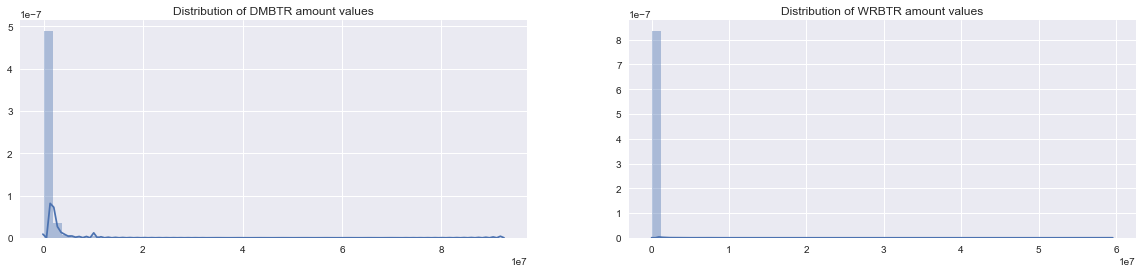

In [19]:
# initialisierung des Plots
fig, ax = plt.subplots(1,2)

# setzen der Breite des Plots
fig.set_figwidth(20)

# zeichnen der Verteilung des Merkmals "Betrag in Systemwährung"
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])

# hinzufügen des Titels des ersten Plots
g.set_title('Distribution of DMBTR amount values')

# zeichnen der Verteilung des Merkmals "Betrag in Belegwährung"
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])

# hinzufügen des Titels des zweiten Plots
g.set_title('Distribution of WRBTR amount values');

Erwartungsgemäß ist zu beobachten, dass für beide Attributen die Betragswertverteilungen sich stark innerhalb des Wertebereichs geringer Buchungsbeträge konzentriert. Um im Rahmen des Modelltrainings schneller zu einem hinreichend optimalen Modell zu konvergieren ist es sinnvoll, die numerischen Eingabewerte entsprechend zu skalieren und zu normieren. Nachfolgend werden deshalb die Betragsausprägungen beider Merkmale logarithmisch skaliert und anschließend die skalierten Beträge auf das Intervall [0, 1] min-max normiert.

In [20]:
# auswahl der numerischen Merkmale
numeric_attr_names = ['DMBTR', 'WRBTR']

# hinzfügen eines kleinen Wertes zur Umgehung der log(0) undefiniertheit
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7

# logarithmische Skalierung der Beträge
numeric_attr = numeric_attr.apply(np.log)

# normalisierung der Werte auf das Intervall [0, 1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

Visualiserung der logarithmisch skalierten und min-max normierten Betragsverteilungen beider Merkmale:

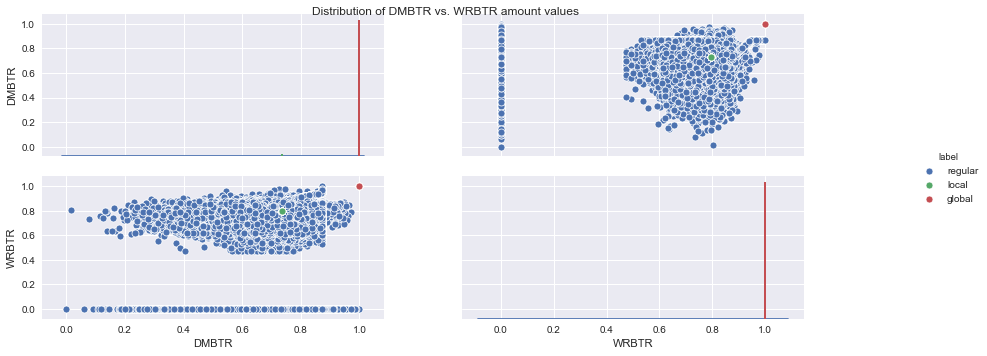

In [21]:
# hinzufügen des labels im Rahmen der Visalisierung
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label

# zeichnen der Verteilung der Merkmale "Betrag in Systemwährung" und "Betrag in Belegwährung"
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label')

# setzen der Länge und Breite des Plots
g.fig.set_size_inches(15, 5)

# hinzufügen des Titels
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values');

Wie erwartet fallen die numerischen Merkmalswerte der "globalen" Anomalien (grün) aufgrund ihrer ungewöhnlich hohen Betragswerte außerhalb des Bereichs der regulären Betragsverteilungen. Im Gegensatz dazu lassen sich die numerischen Attributwerte der "lokalen" Anomalien (orange) innerhalb der regulären Transaktionsbeträge beobachten.

#### 3.4. Zusammenführen der aufbereiteten Datenfelder

Schließlich fügen wir sowohl die vorverarbeiteten numerischen als auch die kategorischen Merkmale zu einem einzigen Datensatz zusammen. Dieser wird anschließend für das Training des Neuronalen Autoencoder Netzes verwendet:

In [22]:
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

Verfikation der Dimensionalität des Datensatzes nach der Zusammenführung beider klassen vorverabeiteter Buchungsmerkmale:

In [23]:
ori_subset_transformed.shape

(533009, 618)

Nach Abschluss aller Vorverarbeitungsschritte umfasst der Datensatz, insgesamt 533.009 Buchungen (Zeilen) und **618 kodierte Buchungsmerkmale** (Spalten). Die Anzahl der kodierten Buchungsmerkmale werden wir nachfolgend benötigen, da sie die Dimensionalität der Ein- und Ausgabeschicht des zu implementierenden Neuronalen Autoencoder Netzes determiniert.

### 4. Maschinelle Lern- und Analyseverfahren

Das Ziel dieses Abschnitts ist es, uns mit der zugrunde liegenden Idee und der Architektur eines tiefen **Neuronalen Autoencoder Netzes (AENN)** vertraut zu machen. Wir werden die wichtigsten Bausteine und die spezifische Netzwerkstruktur von AENNs sowie eine beispielhafte Implementierung unter Verwendung der Open-Source-Bibliothek PyTorch für maschinelles Lernen behandeln.

<img align="center" style="max-width: 800px; height: auto" src="01_images/analytics.png">

#### 4.1. Architektur Neuronaler Autoencoder Netze

AENNs oder "Replicator Neural Networks" sind eine Variante der allgemeinen feed-forward-neuronalen Netze, die ursprünglich von Hinton und Salakhutdinov in [1] eingeführt wurden. AENNs bestehen in der Regel aus einer **symmetrischen Netzwerkarchitektur** sowie einer zentralen, verborgenen Schicht, die als **"latente "** oder **"Kodierungs "schicht** bezeichnet wird und geringere Dimensionalität als die Eingabeschichten des Netzwerk aufweist. Dieses Design ist bewusst gewählt, da das Trainingsziel eines AENNs darin besteht, die Eingabedaten "unsupervised" aus einer niedrig dimensionalen Representation der Eingabedaten zu rekonstruieren.

<img align="middle" style="max-width: 600px; height: auto" src="01_images/autoencoder.png">

**Bild 3:** Schematische Darstellung eines Auto-Encoder-Netzwerks, das aus zwei nichtlinearen Projektionen (vollständig verbundene, vorwärtsgekoppelte neuronale Netze) besteht, die als Encoder Netzwerk $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$ und Decoder Netzwerk $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dx}$ bezeichnet werden.

AENNs können als "verlustbehaftete" Daten **Kompressionsalgorithmen** interpretiert werden. Sie sind "verlustbehaftet" in dem Sinne, dass die rekonstruierten Ausgabedaten im Vergleich zu den ursprünglichen Eingabedaten einen Informationsverlust aufweisen. Die Differenz zwischen den ursprünglichen Eingangsdaten $x^i$ und ihrer jeweiligen Rekonstruktion $\hat{x}^i$ wird oftmals als **Rekonstruktionsfehler** bezeichnet. 

Im Allgemeinen umfasst die Architektur eines Neuronalen Autoencoder Netzes die nachfolgenden drei Elemente:

> 1. eine enkodierende Projektionsfunktion $f_\theta$, 
> 2. eine dekodierende Projektionsfunktion $g_\theta$, 
> 3. und einer Fehlerfunktion $\mathcal{L_{\theta}}$ zur Messung des Rekonstruktionsfehlers.

Im Allgemeinen besteht die enkodierende und dekodierende Projektionsfunktion jeweils aus **mehreren Schichten künstliche Neuronen** parametrisiert durch die Parameter $\theta$. Die enkodierende Projektion $f_\theta(\cdot)$ projeziert einen Eingangsvektor (z.B. eine "one-hot" kodierte Buchung) $x^i$ auf eine komprimierte (d.h. niedrig-dimensionale) Darstellung bezeichnet als Representation $z^i$. Der Raum in welcher diese niedrig-dimensionalen Projektionen leben werden gewöhnlich auch als **latenter Raum $Z$** bezeichnet.

Die niedrig-dimensionalen Repräsentationen $z^i$ wird durch die dekodierende Projektion $g_\theta(\cdot)$ auf einen rekonstruierten Ausgabevektor $\hat{x}^i$ des ursprünglichen Raumes (z.B. die rekonstruierte dekodierte Buchung) zurück abgebildet. Formal können diese nicht-linearen Enkodier- und Dekodierprojektionen wie nachfolgend definiert werden:

<center>$f_\theta(x^i) = s(Wx^i + b)$, and $g_\theta(z^i) = s′(W′z^i + d)$,</center>

wobei $s$ and $s′$ nicht-lineare Aktivierungsfunktionen mit Modellparametern $\theta = \{W, b, W', d\}$ bezeichnen, $W \in \mathbb{R}^{d_x \times d_z}, W' \in \mathbb{R}^{d_z \times d_y}$ bezeichnen die Gewichtsmatritzen und $b \in \mathbb{R}^{dx}$, $d \in \mathbb{R}^{dz}$ bezeichnet die Biasvektoren.

#### 4.2. Implementierung Neuronaler Autoencoder Netze

Beginnen wir nun mit der Implementierung des AENN, indem wir zunächst das Encoder-Netzwerk in PyTorch implementieren. Das Encoder-Netzwerk soll aus **neun vollständig verbundenen Neuronenschichten** bestehen. Die Anzahl der Neuronen pro Schicht wird hierbei wie folgt definiert: "618-256-128-64-32-16-8-4-3". Dies beschreibt, dass die erste Schicht aus insgesamt 618 Neuronen besteht (spezifiziert durch die Dimensionalität der Eingabedaten), die zweite Schicht aus insgesamt 256 Neuronen besteht und die nachfolgenden Schichten aus 128, 64, 32, 16, 8, 4 und 3 Neuronen bestehen.

Bitte beachten Sie einige Elemente der nachfolgenden Implementierung des Encoder-Netzwerkes:

>- `self.encoder_Lx`: definiert die lineare Transformation einer Neuronenschicht $Wx + b$.
>- `nn.init.xavier_uniform`: initialisert die Gewichte einer Neuronenschicht gemäß [3]. 
>- `self.encoder_Rx`: definiert die nichtlineare Transformation einen Neuronenschicht: $\sigma(\cdot)$.

Wir verwenden sog. **"Leaky ReLUs "**, wie von Xu et al. in [2] eingeführt, um "absterbende" Neuronen zu vermeiden und die Trainingskonvergenz zu beschleunigen. Leaky ReLUs erlauben einen kleinen Gradientenwert, auch wenn ein bestimmtes Neuron nicht aktiv ist.

In [24]:
# implementierung des Encoder-Netzwerks
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # spezifikation der Neuronenschicht 1 - Eingabe-Dimensionen 618, Ausgabe-Dimensionen 512
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=512, bias=True) # hinzufügen der linearität
        nn.init.xavier_uniform_(self.encoder_L1.weight) # initialisiere die Gewichte entsprechend [3]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # hinzufügen der nicht-linearität entsprechend [4]

        # spezifikation der Neuronenschicht 2 - Eingabe 512, Ausgabe 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 3 - Eingabe 256, Ausgabe 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 4 - Eingabe 128, Ausgabe 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 5 - Eingabe 64, Ausgabe 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 6 - Eingabe 32, Ausgabe 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 7 - Eingabe 16, Ausgabe 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 8 - Eingabe 8, Ausgabe 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 9 - Eingabe 4, Ausgabe 3
        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
    def forward(self, x):

        # definition des Datenflusses durch das Encoder-Netzwerks
        x = self.encoder_R1(self.encoder_L1(x))
        x = self.encoder_R2(self.encoder_L2(x))
        x = self.encoder_R3(self.encoder_L3(x))
        x = self.encoder_R4(self.encoder_L4(x))
        x = self.encoder_R5(self.encoder_L5(x))
        x = self.encoder_R6(self.encoder_L6(x))
        x = self.encoder_R7(self.encoder_L7(x))
        x = self.encoder_R8(self.encoder_L8(x))
        x = self.encoder_R9(self.encoder_L9(x))

        return x

Initialisierung des zuvor definierten Encoder-Netzwerks:

In [25]:
encoder_train = encoder()

Sobald das Netzwerk initialisiert wurde ist es mögllich die Netzwerkarchitektur durch Ausführung der nachfolgenden Befehle zu überprüfen:

In [26]:
now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Encoder-Netzwerk Architektur:\n\n{}\n'.format(now, encoder_train))

[LOG 20200111-11:05:08] Encoder-Netzwerk Architektur:

encoder(
  (encoder_L1): Linear(in_features=618, out_features=512, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=512, out_features=256, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=256, out_features=128, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L4): Linear(in_features=128, out_features=64, bias=True)
  (encoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L5): Linear(in_features=64, out_features=32, bias=True)
  (encoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L6): Linear(in_features=32, out_features=16, bias=True)
  (encoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L7): Linear(in_features=16, out_features=8, bias=True)
  (encoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L8): Linear(in_features=8, out

Lassen Sie uns nun in einem nächsten Schritt die Architektur des AENN vervollständigen, indem wir das entsprechende Decoder-Netzwerk implementieren. Das Decoder-Netzwerk besteht ebenfalls aus neun vollständig miteinander verbundenen Neuronenschichten. Darüber hinaus soll das Decoder-Netzwerk die Architektur des Encoder-Netzwerks durch eine schichtweise Umkehrung "3-4-8-16-32-64-128-256-618" der Neuronenschichten des Encoder-Netzwerks **symmetrisch** spiegeln.

In [27]:
## implementierung des Decoder-Netzwerks
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # spezifikation der Neuronenschicht 1 - Eingabe-Dimensionen 3, Ausgabe-Dimensionen 4
        self.decoder_L1 = nn.Linear(in_features=3, out_features=4, bias=True) # hinzufügen der linearität
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # initialisiere die Gewichte entsprechend [3]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # hinzufügen der nicht-linearität entsprechend [4]

        # spezifikation der Neuronenschicht 2 - Eingabe 4, Ausgabe 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 3 - Eingabe 8, Ausgabe 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 4 - Eingabe 16, Ausgabe 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 5 - Eingabe 32, Ausgabe 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 6 - Eingabe 64, Ausgabe 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # spezifikation der Neuronenschicht 7 - Eingabe 128, Ausgabe 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 8 - Eingabe 256, Ausgabe 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # spezifikation der Neuronenschicht 9 - Eingabe 512, Ausgabe 618
        self.decoder_L9 = nn.Linear(in_features=512, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    def forward(self, x):

        # definition des Datenflusses durch das Decoder-Netzwerks
        x = self.decoder_R1(self.decoder_L1(x))
        x = self.decoder_R2(self.decoder_L2(x))
        x = self.decoder_R3(self.decoder_L3(x))
        x = self.decoder_R4(self.decoder_L4(x))
        x = self.decoder_R5(self.decoder_L5(x))
        x = self.decoder_R6(self.decoder_L6(x))
        x = self.decoder_R7(self.decoder_L7(x))
        x = self.decoder_R8(self.decoder_L8(x))
        x = self.decoder_R9(self.decoder_L9(x))
        
        return x

Initialisierung des zuvor definierten Decoder-Netzwerks und prüfen der Netzwerkarchitektur:

In [28]:
# initialiserung des Decoder-Netzwerks
decoder_train = decoder()
    
# prüfen der Netzwerkarchitektur
now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20200111-11:05:08] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=4, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L2): Linear(in_features=4, out_features=8, bias=True)
  (decoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L3): Linear(in_features=8, out_features=16, bias=True)
  (decoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L4): Linear(in_features=16, out_features=32, bias=True)
  (decoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L5): Linear(in_features=32, out_features=64, bias=True)
  (decoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L6): Linear(in_features=64, out_features=128, bias=True)
  (decoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L7): Linear(in_features=128, out_features=256, bias=True)
  (decoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L8): Linear(in_features=256, out_features=512,

#### 4.2. Training Neuronaler Autoencoder Netze

Nach Implementierung und Initialisierung des Neuronalen Autoencoder Netzes möchten wir in einem nächsten Schritt das Netzwerk trainieren. Bevor wir jedoch mit dem Training beginnen, ist es Zunächst notwendig eine geeignete Fehlerfunktion zu definieren. Erinnern Sie sich, dass wir unser Modell trainieren wollen, um einen Satz von Encoder-Decoder-Modellparametern $\theta$ zu lernen, welche die Ähnlichkeit einer gegebenen Buchung $x^{i}$ und ihrer Rekonstruktion $\hat{x}^{i} = g_\theta(f_\theta(x^{i}))$ so getreu wie möglich maximiert. 

Dabei ist das Trainingsziel, einen Satz optimaler Encoder-Decoder-Modellparameter $\theta^*$ zu lernen, welche die Zielfunktion $\arg\min_{\theta} \|X - g_\theta(f_\theta(X))\|$ über alle Buchungen $X$ optimiert. Um dieses Optimierungsziel zu erreichen, minimiert man üblicherweise eine Fehlerfunktion $\mathcal{L_{\theta}}$ als Teil des Netzwerktrainings. Nachfolgend werden wir im Rahmen des Netzwerktrainings den Rekonstruktionsfehler in Form des sogenannten **Binary-Cross-Entropy-Error (BCE)** minimieren. Die BCE-Fehlerfunktion ist formal definiert durch:

<center> $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i}) = \frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{k} x^{i}_{j} ln(\hat{x}^{i}_{j}) + (1-x^{i}_{j}) ln(1-\hat{x}^{i}_{j})$, </center>

für ein Set von $n$-Buchungen $x^{i}$, $i=1,...,n$ und ihre jeweiligen Rekonstruktionen $\hat{x}^{i}$ über alle Buchungsmerkmale $j=1,...,k$. Im Rahmen des Netwerktrainings Trainings wird die Fehlerfunktion solche Modelle bestrafen, die zu einer hohen Unähnlichkeit zwischen den eingegebenen Journaleinträgen und ihren jeweiligen Rekonstruktionen führen. 

Eine Implementierung der BCE-Fehlerfunktion ist bereits in PyTorch verfügbar. Sie kann deshalb unmittelbar durch Ausführung des folgenden PyTorch-Befehls instanziiert werden:

In [29]:
loss_function = nn.BCEWithLogitsLoss(reduction='mean')

(Anmerkung: Die Aktivierung des Parameters `reduction` legt fest, dass die Verluste über alle Beobachtungen über jeden Mini-Batch an Trainingsbuchungen gemittelt werden).

Basierend auf der Höhe des Fehlers für einen bestimmten Mini-Batch an Trainingsbuchungen berechnet PyTorch automatisiert die Gradienten. Basierend auf den ermittelten Gradienten, können anschließend die Parameter $\theta$ des Neuronalen Autoencoder Netzes optimiert werden.

Für die Optimierung der Parameter werden wir die **Adam-Optimierungsstrategie** wie in [5] vorgestellt verwenden. Darüber hinaus verwemdem wir eine Lernrate von $l = 0.001$ im Rahmen des Trainingsprozesses. Für jeden Mini-Batch optimiert die Adam-Optimierung hierbei die Werte der Encoder- und Decoder-Parameter $\theta$ entsprechend der Höhe des Rekonstruktionsfehlers ermittelt anhand der BCE-Fehlerfunktion.

Setzen der Lernrate und Definition der Optimerungsstrategie:

In [30]:
# setzen der Lernrate
learning_rate = 1e-3

# definition der Optimierungsstrategie
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

Beginnen wir nun mit dem Training eines entsprechenden Modells für **5 Trainingsepochen** und einer **Mini-Batch-Größe von 128** Buchungen pro Batch. Dies bedeutet, dass der gesamte Datensatz 5 mal in Tranchen von jeweils 128 Buchungen durch das AENN verabeitet wird. Hieraus ergibt sich eine Verarbeitung von insgesamt 4.165 Mini-Batches (533.009 Journaleinträge / 128 Journaleinträge pro Mini-Batch) pro Trainingsepoche

In [31]:
# setzen der Anzahl der Trainingsepochen
num_epochs = 5

# setzen der Anzahl der Buchungen pro Mini-Batch
mini_batch_size = 128

Während der Trainingsphase werden kontinuerlich einzelne Mini-Batches von Buchungen durch das Neuronale Autoencoder Netzwerk verabeitet. Um die batchweise Bereitstellung der Daten während des Trainingsprozesses zu gewährleisten, nutzen wir die bereits durch PyTorch bereitgestellte `DataLoader` Funktionalität. Durch  das Aktivieren des Parameters `shuffle=True` werden zudem die Daten in jeder Epoche neu gemischt, bevor sie in das Netzwerk eingespeist werden. 

Konvertierung der Buchungsdaten und Initialiserung des PyTorch `DataLoader`'s:

In [32]:
# konvertierung der Buchungsdaten in einen PyTorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# initialisierung des PyTorch DataLoaders
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True)

Schließlich beginnen wir mit dem Training des Neuronalen Autoencoder Netzwerks und der Ausbildung des Modells. Für jeden Mini-Batch an Buchungen werden hierbei die nachfolgenden vier Schritte im Rahmen des Trainings vollzogen:

>1. Vorwärtsverarbeitung der Buchungen durch das Neuronale Autoencoder Netzwerk, 
>2. Berechnung des BCE-Rekonstruktionsfehlers $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i})$, 
>3. Rückwärtsverarbeitung des ermittelten Rekonstruktionsfehlers durch das Neuronale Autoencoder Netzwerk, 
>4. Aktualisieren der Netzwerkparameter des Encoders $f_\theta(\cdot)$ und Decoders $g_\theta(\cdot)$.

Im Rahmen des Trainingsprozesses wird überwacht, ob der Rekonstruktionsfehler der einzelnen Buchungen mit fortschreitendem Training abnimmt. Deshalb messen wir nach jeder Trainingsepoche den Rekonstruktionsfehler des gesamten Datensatzes. Anhand dieser Auswertung lässt sich der Trainingsfortschritt bewerten bzw. ob der Rekonstruktionsfehler nach einer gewissen Anzahl Trainingsepochen konvergiert (was darauf hindeutet, dass sich die Modellgüte möglicherweise nicht weiter verbessert).

Die nachfolgende Code-Zelle des Notebooks implementiert die einzelnen Schritte des Trainingsprozesses. Hierbei sollten den folgenden Befehlen des untenstehenden Netzwerk-Trainingscodes sollten besondere Beachtung geschenkt werden:
 
>- `reconstruction_loss.backward()` berechnet die Gradienten basierend auf der Größe des Rekonstruktionsfehlers,
>- `encoder_optimizer.step()` und `decoder_optimizer.step()` aktualisiert die Parameter des Encoder- und Decoder-Netzwerkes basierend auf dem Gradienten.

Zusätzlich wollen wir nach jeder Trainingsepoche einen sog. Kontrollpunkt ("Checkpoint") des erlenten Modells speichern. Diese gespeicherten Kontrollpunkte enthalten eine Momentaufnahme aller Modellparameter zu einem bestimmten Trainingszeitpunkt (z.B. einer bestimmten Trainingsepoche). Im Allgemeinen ist es gute Praxis, die Kontrollpunkte in regelmäßigen Abständen während des Trainings zu speichern. Sollte das Training einmal unterbrochen werden, können Sie das Modelltraining einfach ausgehend vom letzten gespeicherten Kontrollpunkt weiterführen:

>- `torch.save()`: speichert einen Kontrollpunkt der aktuellen Modellparameter in eine lokale Datei.

In [33]:
# init collection of mini-batch losses
losses = []

# konvertiere die Buchungsdaten nach autograd
data = autograd.Variable(torch_dataset)

# iteriere über die Anzahl der Trainingsepochen
for epoch in range(num_epochs):

    # reset des mini-batch Zählers
    mini_batch_count = 0
    
    # versetzen des Netzwerks in den Trainingsmodus
    encoder_train.train()
    decoder_train.train()

    # starte die Trainingszeitmessung
    start_time = dt.datetime.now()
        
    # iteriere über die Anzahl der Mini-Batches per Trainingsepoche
    for mini_batch_data in dataloader:

        # erhöhung des mini-batch Zählers
        mini_batch_count += 1

        # konvertiere die Mini-Batch Daten nach autograd
        mini_batch_torch = autograd.Variable(mini_batch_data)

        # =================== (1) Vorwärtsverarbeitung ===================================

        # durchführen der Vorwärtsverarbeitung
        z_representation = encoder_train(mini_batch_torch) # enkodierung der mini-batch Daten
        mini_batch_reconstruction = decoder_train(z_representation) # dekodierung der mini-batch Daten
        
        # =================== (2) Berechnung des Rekonstruktionsfehlers ====================

        # berechnung des Rekonstruktionsfehlers
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_torch)
        
        # =================== (3) Rückwärtsverarbeitung ==================================

        # reset der Modellgradienten
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # durchführen der Rückwärtsverarbeitung
        reconstruction_loss.backward()
        
        # =================== (4) Update der Modellparameter ========================

        # update der Modellparameter
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== Monitoring des Trainingsfortschritts ==========================

        # ausgabe des Rekonstruktionsfehlers nach jedem 1000-ten Mini-Batch
        if mini_batch_count % 1000 == 0:
        
            # ausgabe des Mini-Batch Rekonstruktionsfehlers
            now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            end_time = dt.datetime.now() - start_time
            print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}, loss: {}, time required: {}'.format(now, (epoch+1), num_epochs, mini_batch_count, np.round(reconstruction_loss.item(), 4), end_time))

            # resete die Trainingszeitmessing
            start_time = dt.datetime.now()

    # =================== Evaluation der Modellperformance =============================
    
    # versetzen des Netzwerks in den Evaluationsmodus
    encoder_train.eval()
    decoder_train.eval()

    # rekonstruktion der enkodierten Gesamtdaten
    reconstruction = decoder_train(encoder_train(data))
    
    # berechnung des Rekonstruktionsfehlers über den Gesamtdatenbestand
    reconstruction_loss_all = loss_function(reconstruction, data)
            
    # logging des Rekonstruktionsfehlers über den Gesamtdatenbestand
    losses.extend([reconstruction_loss_all.item()])
    
    # ausgabe des Rekonstruktionsfehlers über den Gesamtdatenbestand
    now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, reconstruction_loss_all.item()))

    # =================== Speichern eines Kontrollpunkts ============================
    
    # speichern des Encoder Kontrollpunktes
    encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./04_models", encoder_model_name))

    # speichern des Decoder Kontrollpunktes
    decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./04_models", decoder_model_name))

[LOG 20200111-11:05:25] training status, epoch: [0001/0005], batch: 1000, loss: 0.0155, time required: 0:00:13.819903
[LOG 20200111-11:05:42] training status, epoch: [0001/0005], batch: 2000, loss: 0.0118, time required: 0:00:16.737164
[LOG 20200111-11:06:01] training status, epoch: [0001/0005], batch: 3000, loss: 0.0094, time required: 0:00:18.803346
[LOG 20200111-11:06:21] training status, epoch: [0001/0005], batch: 4000, loss: 0.007, time required: 0:00:19.482370
[LOG 20200111-11:06:39] training status, epoch: [0001/0005], loss: 0.0074817073
[LOG 20200111-11:07:00] training status, epoch: [0002/0005], batch: 1000, loss: 0.0067, time required: 0:00:21.068071
[LOG 20200111-11:07:22] training status, epoch: [0002/0005], batch: 2000, loss: 0.0068, time required: 0:00:21.732666
[LOG 20200111-11:07:44] training status, epoch: [0002/0005], batch: 3000, loss: 0.0063, time required: 0:00:22.010851
[LOG 20200111-11:08:07] training status, epoch: [0002/0005], batch: 4000, loss: 0.006, time req

Auf Grundlage der erzeugten Ausgabe im Trainingsverlauf lässt sich beobachten, dass der Rekonstruktionsfehler mit fortschreitendem Training des Modells kontinuierlich abnimmt.

Visualisierung des Rekonstruktionsfehlers pro Trainingsepoche:

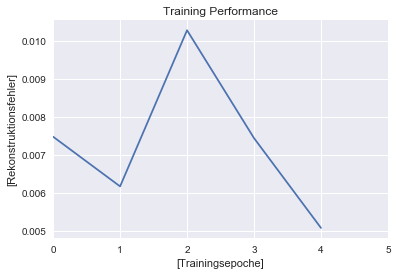

In [34]:
# initialisierung des Plots
fig, ax = plt.subplots()

# zeichnen des Rekonstruktionsfehlers mit fortschreitendem Training
plt.plot(range(0, len(losses)), losses)

# hinzufügen der Achsenbeschriftungen
plt.xlabel('[Trainingsepoche]')
plt.ylabel('[Rekonstruktionsfehler]')

# setzen des Wertebereichs der x-Achse
plt.xlim([0, len(losses)])

# hinzufügen des Titels
plt.title('Training Performance');

Es lässt sich beobachten, dass der Rekonstruktionsfehler bereits nach 5 Trainingsepochen deutlich reduziert werden konnte. Dies deutet darauf hin, dass das Neuronale Autoencoder Netzwerk in der Lage ist kontinuierlich mehr über die inherente Struktur und Zusammenhänge der in den Buchungen enthaltenen Merkmale zu lernen.

Aus der Visualisierung lässt sich erkennen, dass das Modell wahrscheinlich noch ein paar Epochen mehr trainiert werden könnte. Der Rekonstruktions- fehler scheint mit zunehmenden Training immer noch abzunehmen bzw. konvergiert noch nicht. Um etwas Zeit zu sparen, werden wir nun das Lab mit einem über 20 Trainingsepochen vortrainierten Modell fortsetzen.

#### 4.3. Anwendung des trainierten Modells

Nach erfolgreichem Modelltraining möchten wir das erlernte Modell über die Zusammenhänge in den Buchungen nun  nutzen, um Anomalien innerhalb der Grundgesamtheit an Buchungen zu erkennen. Hierzu werden wir zunächst ein bereits über 20 Trainingsepochen trainiertes Modell laden und die Rekonstruktionsfähigkeit des Modells auf dem gesamten Datensatz zu bewerten.

Das vortrainierte Modell wurde im gleichen Unterverzeichnis wie die übrigen Modelle gespeichert und kann durch Ausführen der Code-Zelle unten in das Notebook geladen werden: 

In [35]:
# setzen der zu ladenden Kontrollpunkt-Dateinamen
encoder_model_name = "ep_20_encoder_model.pth"
decoder_model_name = "ep_20_decoder_model.pth"

# initialisierung de
encoder_eval = encoder()
decoder_eval = decoder()

# laden der Modellparameter
encoder_eval.load_state_dict(torch.load(os.path.join("04_models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("04_models", decoder_model_name)));

Anwendung und Evaluation des Modells zur Ermittlung der Rekonstruktion aller Buchungen:

In [36]:
# konvertiere die Buchungsdaten nach autograd
data = autograd.Variable(torch_dataset)

# versetzen des Netzwerks in den Evaluationsmodus
encoder_eval.eval()
decoder_eval.eval()

# rekonstruktion der Grundgesamtheit aller Buchungen
reconstruction = decoder_eval(encoder_eval(data))

Berechnung der individuellen Rekonstruktionsfehler der einzelnen Buchungen:

In [37]:
# initialisierung der individuellen Rekonstruktionsfehler pro Buchung
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iteration über die individuellen Buchungen
for i in range(0, reconstruction.size()[0]):

    # ermittlung des Rekonstruktionsfehlers pro Buchung
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).item()

    if(i % 100000 == 0):

        ### ausgabe des Fortschritts der ermittelten Rekonstruktionsfehler
        now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))
        

[LOG 20200111-11:14:34] collected individual reconstruction loss of: 000000/533009 transactions
[LOG 20200111-11:14:39] collected individual reconstruction loss of: 100000/533009 transactions
[LOG 20200111-11:14:43] collected individual reconstruction loss of: 200000/533009 transactions
[LOG 20200111-11:14:48] collected individual reconstruction loss of: 300000/533009 transactions
[LOG 20200111-11:14:53] collected individual reconstruction loss of: 400000/533009 transactions
[LOG 20200111-11:14:57] collected individual reconstruction loss of: 500000/533009 transactions


Visualisierung der individuallen Rekonstruktionsfehler pro Buchung:

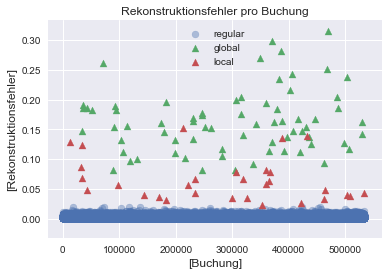

In [38]:
# initialisierung des Plots
fig = plt.figure()
ax = fig.add_subplot(111)

# zuordnung eines eindeutigen Buchungskennzeichens
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))

# filtern der gewöhnlichen Buchungen
regular_data = plot_data[label == 'regular']

# filtern der globalen Anomalien
global_outliers = plot_data[label == 'global']

# filtern der lokalen Anomalien
local_outliers = plot_data[label == 'local']

# zeichne die Rekonstruktionsfehler der regulären Buchungen
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', alpha=0.4, marker="o", label='regular')

# zeichne die Rekonstruktionsfehler der globalen Anomalien
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", label='global')

# zeichne die Rekonstruktionsfehler der lokalen Anomalien
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="^", label='local')

# hinzufügen der Achsenbeschriftungen
ax.set_ylabel("[Rekonstruktionsfehler]", fontsize=12)
ax.set_xlabel("[Buchung]", fontsize=12)

# hinzufügen der Legende
ax.legend(loc='best')

# hinzufügen des Titels
ax.set_title("Rekonstruktionsfehler pro Buchung");

Die Visualisierung zeigt, dass das trainierte Modell in der Lage ist, den Großteil der regulären Buchungen zu rekonstruieren. Jedoch gelingt dies nicht für die "Anomalien" d.h. der aufgrund Ihrer Merkmalsausprägungen bzw. Merkmalskombination ungewöhnlichen Buchungen im Datensatz. Im Ergebnis, ist es möglich Anhand des  Rekonstruktionsfehlers unüberwacht sowohl "globale" Anomalien (orange) als auch "lokale" Anomalien (grün) von den regulären Buchungen (blau) zu unterscheiden.

Um diese Beobachtung weiter zu untersuchen und die obige Annahme zu bestätigen, wollen wir nun einen genaueren Blick auf die Buchungen werfen, die einen hohen Rekonstruktionsfehler aufweisen. Wir nehmen an, dass diese Journaleinträge den "globalen" Anomalien des ursprünglichen Datensatzes entsprechen:

In [39]:
# hinzufügen der Label Information
ori_dataset['label'] = label

# filtern der Buchungen die einen Rekonstruktionsfehler >= 0.1 aufweisen
global_anomalies = ori_dataset[reconstruction_loss_transaction >= 0.1]

Erzeugung eines Analysezeitstempels:

In [40]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Festlegung des Dateinamens der zu speichernden Analyseergebnisse:

In [41]:
filename = "B001_" + str(timestamp) + "_analysis_result_global_anomalies.csv"

Festlegung des Verzeichnises der zu speichernden Analyseergebnisse:

In [42]:
directory = os.path.join(os.getcwd(), '03_results', filename)

Speichern der Analyseergebnisse auf dem lokalen Dateisystem:

In [43]:
global_anomalies.to_csv(directory, sep=",", header=True, index=False, encoding="utf-8")

Schauen wir uns nun auch die Buchungen genauer an, die einen geringeren Rekonstruktionsfehler >= 0.02 und < 0.1 aufweisen. Wir gehen davon aus, dass diese Buchungen größtenteils den "lokalen" Anomalien des Originaldatensatzes entsprechen:

In [44]:
# ausgabe der Buchungen die einen Rekonstruktionsfehler zwischen 0.02 und 0.1 aufweisen
local_anomalies = ori_dataset[(reconstruction_loss_transaction >= 0.02) & (reconstruction_loss_transaction < 0.1)]

Erzeugung eines Analysezeitstempels:

In [45]:
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

Festlegung des Dateinamens der zu speichernden Analyseergebnisse:

In [46]:
filename = "B002_" + str(timestamp) + "_analysis_result_global_anomalies.csv"

Festlegung des Verzeichnises der zu speichernden Analyseergebnisse:

In [47]:
directory = os.path.join(os.getcwd(), '03_results', filename)

Speichern der Analyseergebnisse auf dem lokalen Dateisystem:

In [48]:
local_anomalies.to_csv(directory, sep=",", header=True, index=False, encoding="utf-8")

### Übungen:

Wir empfehlen die Durchführung der nachfolgenden Übungen im Rahmen das Labs:

**1. Analysieren Sie das Detektionsergebnis für verschiedene Netzwerkarchitekturen.**

> Analysieren Sie die Funktionsweise von Neuronalen Autoencoder Netzen indem Sie weitere d.h. "flachere" und "tiefere" Netzarchitekturen trainieren. Dies kann in PyTorch durch das entfernen bzw. hinzufügen von Neuronenschichten der in Kapitel 4.2. vorgestellten Implementierung erfolgen. Evaluieren Sie Ihre Architekturen in Bezug auf (1) Trainingsdauer, (2) Rekonstruktionsfehler und (3) Erkennung der Anomalien innerhalb des Datensatzes. Extrahieren Sie abschließend Ihre Analyseergebnisse in gesonderte CSV-Datei für die ggf. nachgelagerte Einzelfallprüfung.

In [49]:
# ***************************************************
# Bitte geben Sie Ihre Lösung in dieses Feld ein
# ***************************************************

**2. Analysieren Sie das Detektionsergebnis für verschiedene Arten von Anomalien.**

> Analysieren Sie die Funktionsweise von Neuronalen Autoencoder Netzen indem Sie weitere Anomalien in den Datensatz indizieren. Dies kann z.B. im Rahmen der in Kapitel 3. vorgestellten Datenaufbereitung durch den Pandas Aufruf `df.loc[-1]` erfolgen. Evaluieren Sie Ihre Architekturen in Bezug auf die Erkennung der hinzugefügten Anomalien. Extrahieren Sie abschließend Ihre Analyseergebnisse in gesonderte CSV-Datei für die ggf. nachgelagerte Einzelfallprüfung.

In [50]:
# ***************************************************
# Bitte geben Sie Ihre Lösung in dieses Feld ein
# ***************************************************

### Zusammenfassung:

In diesem Lab wurde eine schrittweise Einführung in die Verwendung maschineller Lernverfahren im Rahmen der revisorischen Datenanalyse vorgestellt. Hierbei wurde im Besonderen die **(1) Architektur**, das **(2) Training** und **(3) Analysedurchführung** von Neuronalen Autoencoder Netzen behandelt. Das in diesem Lab präsentierte Analysevorgehen kann einen Ausgangspunkt für komplexere und maßgeschneiderte Analysen darstellen.

### Referenzen:

[1] E. A. Lopez-Rojas , A. Elmir, and S. Axelsson, "PaySim: A financial mobile money simulator for fraud detection", In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus, 2016.

[2] G. E. Hinton, and R. R. Salakhutdinov, "Reducing the dimensionality of data with neural networks", science 313, no. 5786: 504-507, 2006.

[3] X. Glorot and Y. Bengio, "Understanding the difficulty of training deep feedforward neural networks", Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS), 9:249–256, 2010.

[4] B. Xu, N. Wang, T. Chen, and M. Li, "Empirical Evaluation of Rectified Activations in Convolution Network", ICML Deep Learning Workshop, 2015.

[5] D. P. Kingma and J. Ba, "Adam: A method for stochastic optimization", International Conference on Learning Representations (ICLR). 2015.